<a href="https://colab.research.google.com/github/BhumikaAdhya05/BUS-UC-ResUNet-Segmentation/blob/main/ResUNet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d orvile/bus-uc-breast-ultrasound
!unzip -q bus-uc-breast-ultrasound.zip -d bus_uc_data

Dataset URL: https://www.kaggle.com/datasets/orvile/bus-uc-breast-ultrasound
License(s): CC-BY-SA-4.0
 76% 104M/137M [00:00<00:00, 1.08GB/s]
100% 137M/137M [00:00<00:00, 1.06GB/s]


In [4]:
!ls /content/bus_uc_data

BUS_UC	BUS_UC_classification  dataset.csv


In [11]:
!ls /content/bus_uc_data/BUS_UC/BUS_UC/BUS_UC

All  Benign  Malignant


In [14]:
!ls /content/bus_uc_data/BUS_UC/BUS_UC/BUS_UC/Benign | head -10

images
masks


In [15]:
import os
import cv2
import numpy as np
from glob import glob

IMG_SIZE = 128
BASE_DIR = "/content/bus_uc_data/BUS_UC/BUS_UC/BUS_UC"

def load_bus_uc_dataset(img_size=IMG_SIZE):
    images, masks = [], []

    for label in ["Benign", "Malignant"]:
        img_dir = os.path.join(BASE_DIR, label, "images")
        mask_dir = os.path.join(BASE_DIR, label, "masks")

        img_files = sorted(glob(os.path.join(img_dir, "*.png")))

        for img_path in img_files:
            filename = os.path.basename(img_path)
            mask_path = os.path.join(mask_dir, filename)

            if not os.path.exists(mask_path):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                continue

            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))

            img = img.astype(np.float32) / 255.0
            mask = (mask > 0).astype(np.float32)

            images.append(np.expand_dims(img, axis=-1))
            masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)

In [16]:
X, Y = load_bus_uc_dataset()

from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (567, 128, 128, 1)
Val: (122, 128, 128, 1)
Test: (122, 128, 128, 1)


In [18]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, UpSampling2D, Add, Concatenate, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Reshape, Multiply, Dense, Lambda)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    return x

def residual_block(x, filters):
    res = Conv2D(filters, 1, padding='same')(x)
    x = conv_block(x, filters)
    x = Add()([x, res])
    x = Activation("relu")(x)
    return x

def se_block(x, filters):
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // 16, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([x, se])

def aspp_block(x, filters):
    shape = K.int_shape(x)

    y1 = Conv2D(filters, 1, dilation_rate=1, padding='same')(x)
    y2 = Conv2D(filters, 3, dilation_rate=6, padding='same')(x)
    y3 = Conv2D(filters, 3, dilation_rate=12, padding='same')(x)
    y4 = Conv2D(filters, 3, dilation_rate=18, padding='same')(x)

    y = Concatenate()([y1, y2, y3, y4])
    y = Conv2D(filters, 1, padding='same')(y)
    return y

def build_resunetpp(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    ## Encoder
    e1 = residual_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(e1)

    e2 = residual_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(e2)

    e3 = residual_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(e3)

    e4 = residual_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(e4)

    ## Bridge
    b = aspp_block(p4, 256)

    ## Decoder
    u4 = UpSampling2D((2, 2))(b)
    u4 = Concatenate()([u4, e4])
    d4 = residual_block(u4, 256)
    d4 = se_block(d4, 256)

    u3 = UpSampling2D((2, 2))(d4)
    u3 = Concatenate()([u3, e3])
    d3 = residual_block(u3, 128)
    d3 = se_block(d3, 128)

    u2 = UpSampling2D((2, 2))(d3)
    u2 = Concatenate()([u2, e2])
    d2 = residual_block(u2, 64)
    d2 = se_block(d2, 64)

    u1 = UpSampling2D((2, 2))(d2)
    u1 = Concatenate()([u1, e1])
    d1 = residual_block(u1, 32)
    d1 = se_block(d1, 32)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d1)

    return Model(inputs, outputs)

In [19]:
model = build_resunetpp()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 6,073,375 (23.17 MB)

 Trainable params: 6,069,535 (23.15 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [20]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=4,
    verbose=1
)

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 256ms/step - accuracy: 0.8794 - loss: 0.2652 - val_accuracy: 0.8063 - val_loss: 0.4491
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.9386 - loss: 0.1503 - val_accuracy: 0.8935 - val_loss: 0.2560
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9520 - loss: 0.1217 - val_accuracy: 0.9003 - val_loss: 0.2244
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9554 - loss: 0.1134 - val_accuracy: 0.8639 - val_loss: 0.3297
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9625 - loss: 0.0973 - val_accuracy: 0.9578 - val_loss: 0.1092
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9666 - loss: 0.0857 - val_accuracy: 0.9624 - val_loss: 0.0996
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9724 - loss: 0.0712 - val_accuracy: 0.9553 - val_loss: 0.1227
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9740 - loss: 0.0678 - val

In [21]:
results = model.evaluate(X_test, Y_test)
print(f"\n Test Loss: {results[0]:.4f}")
print(f" Test Accuracy: {results[1]*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9779 - loss: 0.0692

 Test Loss: 0.0670
 Test Accuracy: 97.86%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


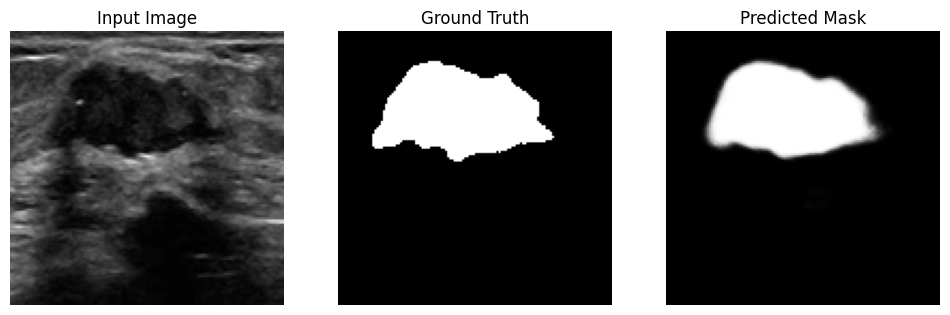

In [22]:
i = np.random.randint(0, len(X_test))
img = X_test[i]
true_mask = Y_test[i]
pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.axis('off')
plt.show()